# A tour of PyCIEMSS interfaces and functionality

### Load dependencies and interfaces

In [1]:
import os
import pyciemss
import torch
import pandas as pd

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

smoke_test = ('CI' in os.environ)

### Select models and data

In [2]:
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
DATA_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/datasets/"

model1 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type1_petrinet.json")
model2 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type2_petrinet.json")
model3 = os.path.join(MODEL_PATH, "SIR_stockflow.json")

dataset1 = os.path.join(DATA_PATH, "SIR_data_case_hosp.csv")
dataset2 = os.path.join(DATA_PATH, "traditional.csv")

### Set parameters for sampling

In [3]:
start_time = 0.0
end_time = 100.
logging_step_size = 10.0
num_samples = 3 if smoke_test else 1000

## Sample interface
Take `num_samples` number of samples from the (prior) distribution invoked by the chosen model.

### Sample from model 1

In [4]:
result1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)
display(result1['data'].head())

# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

ERROR:root:
                ###############################

                There was an exception in pyciemss

                Error occured in function: sample

                Function docs : 
    Load a model from a file, compile it into a probabilistic program, and sample from it.

    Args:
        model_path_or_json: Union[str, Dict]
            - A path to a AMR model file or JSON containing a model in AMR form.
        end_time: float
            - The end time of the sampled simulation.
        logging_step_size: float
            - The step size to use for logging the trajectory.
        num_samples: int
            - The number of samples to draw from the model.
        solver_method: str
            - The method to use for solving the ODE. See torchdiffeq's `odeint` method for more details.
            - If performance is incredibly slow, we suggest using `euler` to debug.
              If using `euler` results in faster simulation, the issue is likely that the model is s

SSLError: HTTPSConnectionPool(host='raw.githubusercontent.com', port=443): Max retries exceeded with url: /DARPA-ASKEM/simulation-integration/main/data/models/SEIRHD_NPI_Type1_petrinet.json (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:997)')))

### Sample from model 2

In [ ]:
result2 = pyciemss.sample(model2, end_time, logging_step_size, num_samples, start_time=start_time)
display(result2['data'].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result2["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Ensemble Sample Interface
Sample from an ensemble of model 1 and model 2 

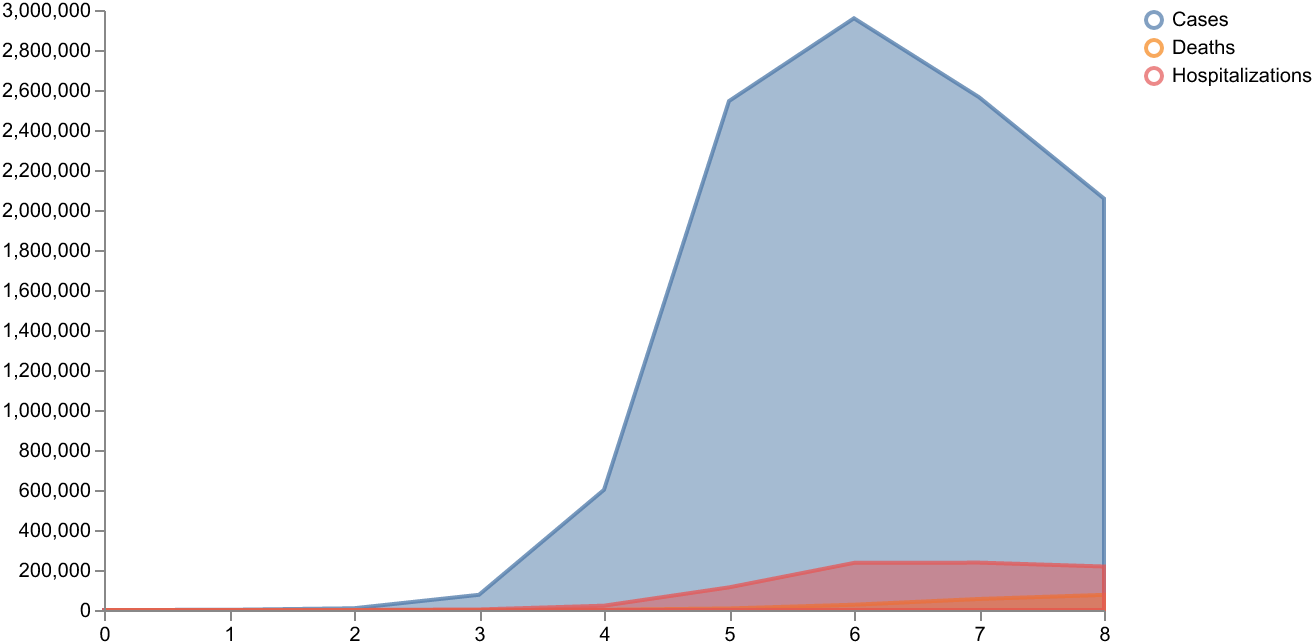

In [6]:
model_paths = [model1, model2]
solution_mappings = [lambda x : x, lambda x : x] # Conveniently, these two models operate on exactly the same state space, with the same names.

ensemble_result = pyciemss.ensemble_sample(model_paths, solution_mappings, end_time, logging_step_size, num_samples, start_time=start_time)
display(ensemble_result['data'].head())

# Plot the ensemble result for cases, hospitalizations, and deaths
nice_labels={"dead_state": "Deaths", 
                 "hospitalized_state": "Hospitalizations",
                 "infected_state": "Cases"
                }
schema = plots.trajectories(ensemble_result["data"], 
                           keep=["infected_state", "hospitalized_state", "dead_state"], 
                           relabel=nice_labels,
                          )
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Calibrate interface
Calibrate a model to a dataset by mapping model state varibale or observables to columns in the dataset

In [18]:
data_mapping = {"case": "I", "hosp": "H"} # data_mapping = {"column_name": "observable/state_variable"}
num_iterations = 10 if smoke_test else 1000
calibrated_results = pyciemss.calibrate(model1, dataset1, data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
calibrated_results

{'inferred_parameters': AutoGuideList(
   (0): AutoDelta()
   (1): AutoLowRankMultivariateNormal()
 ),
 'loss': 10.531517714262009}

In [19]:
parameter_estimates()

{'persistent_beta_c': tensor(0.6150, grad_fn=<ExpandBackward0>),
 'persistent_kappa': tensor(0.6118, grad_fn=<ExpandBackward0>),
 'persistent_gamma': tensor(0.3957, grad_fn=<ExpandBackward0>),
 'persistent_hosp': tensor(0.1448, grad_fn=<ExpandBackward0>),
 'persistent_death_hosp': tensor(0.0481, grad_fn=<ExpandBackward0>),
 'persistent_I0': tensor(9.6574, grad_fn=<ExpandBackward0>)}

### Pass the parameter estimates to `sample` to sample from the calibrated model

,timepoint_id,sample_id,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,0.213311,0.713395,0.410818,0.146705,0.072877,9.357379,0.551195,85.207901,7.891521,41.738220,96.903366,19339806.0,41.738220,85.207901,7.891521,0.551195
1,1,0,0.213311,0.713395,0.410818,0.146705,0.072877,9.357379,2.616651,230.421051,22.648224,112.884476,373.855621,19339294.0,112.884476,230.421051,22.648224,2.616651
2,2,0,0.213311,0.713395,0.410818,0.146705,0.072877,9.357379,8.284684,623.078735,61.423290,305.257507,1123.863281,19337910.0,305.257507,623.078735,61.423290,8.284684
3,3,0,0.213311,0.713395,0.410818,0.146705,0.072877,9.357379,23.622288,1684.402710,166.099426,825.277161,3151.925049,19334188.0,825.277161,1684.402710,166.099426,23.622288
4,4,0,0.213311,0.713395,0.410818,0.146705,0.072877,9.357379,65.083839,4550.187012,448.893616,2229.802490,8633.307617,19324108.0,2229.802490,4550.187012,448.893616,65.083839


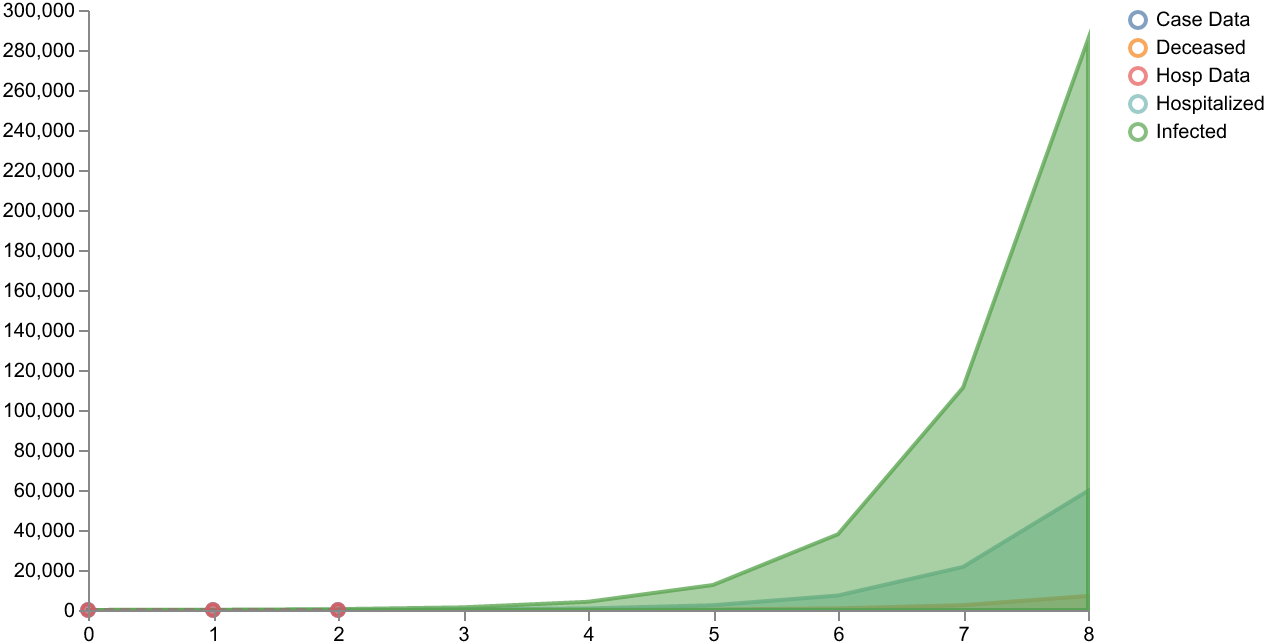

In [36]:
calibrated_sample_results = pyciemss.sample(model1, end_time, logging_step_size, num_samples, 
                start_time=start_time, inferred_parameters=parameter_estimates)
display(calibrated_sample_results["data"].head())

# Plot the result
nice_labels = {
        "dead_observable_state": "Deceased", 
        "hospitalized_observable_state": "Hospitalized",
        "infected_observable_state": "Infected",
        }
nice_data_names = {
        "case": "Case Data",
        "hosp": "Hosp Data"
        }
data_df = pd.read_csv(dataset1)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(pd.DataFrame(calibrated_sample_results["data"]), 
                           keep=["infected_observable_state", "hospitalized_observable_state", "dead_observable_state"], 
                           relabel=nice_labels,
                           points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
                           )

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Sample interface with static parameter intervention
Change the value of the parameter `p_cbeta` to 0.5 on day 1

,timepoint_id,sample_id,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,0.298696,16.558092,1.238005,0.060393,999.701599
1,1,0,0.298696,16.558092,1.781436,0.135161,999.083374
2,2,0,0.298696,16.558092,2.562862,0.242748,998.194336
3,3,0,0.298696,16.558092,3.685921,0.397528,996.916504
4,4,0,0.298696,16.558092,5.298758,0.620133,995.081055


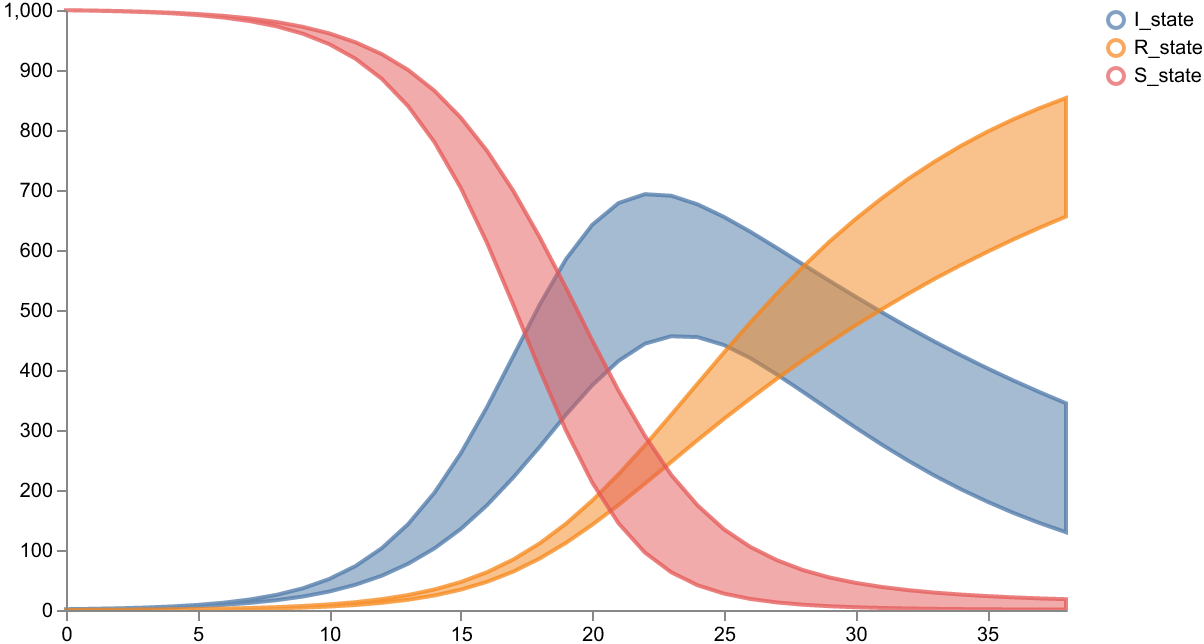

In [39]:
start_time = 0.0
end_time = 40.
logging_step_size = 1.0
num_samples = 5 if smoke_test else 1000

result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         static_parameter_interventions={torch.tensor(1.): {"p_cbeta": torch.tensor(0.5)}}, solver_method="euler")
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Sample interface with static state intervention
Change the Infected state `I` to 20.0 on day 5

,timepoint_id,sample_id,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,0.333943,15.598527,1.269501,0.064109,999.666382
1,1,0,0.333943,15.598527,1.611492,0.145495,999.242981
2,2,0,0.333943,15.598527,2.045383,0.248805,998.705750
3,3,0,0.333943,15.598527,2.595733,0.379932,998.024292
4,4,0,0.333943,15.598527,3.293576,0.546341,997.160034


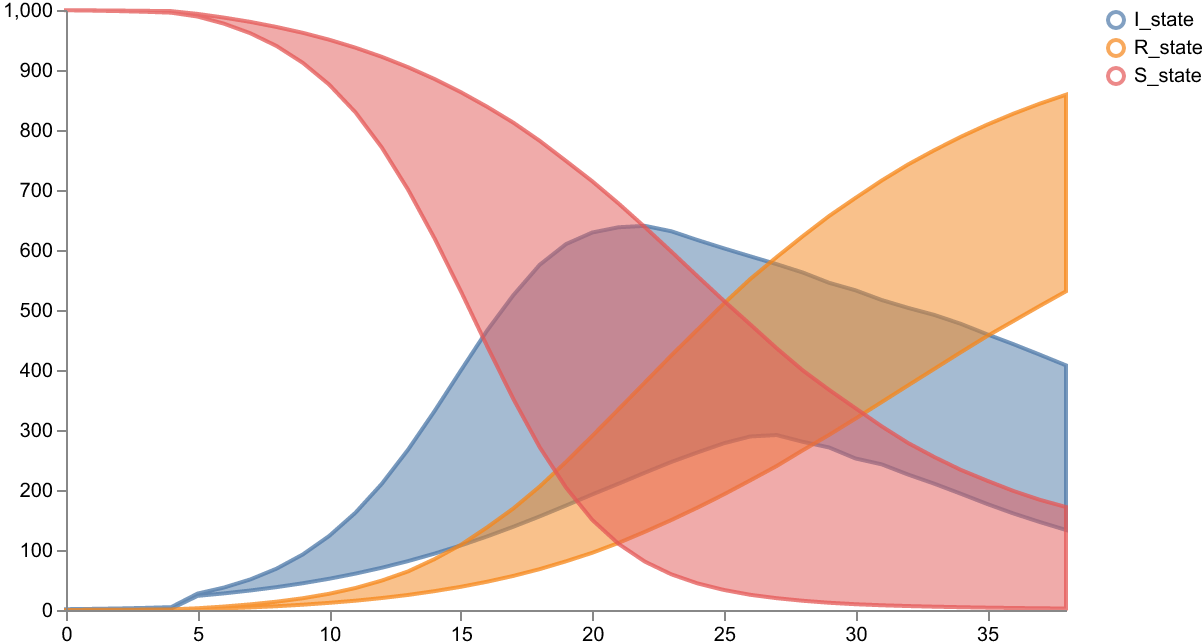

In [40]:
result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         static_state_interventions={torch.tensor(5.): {"I": torch.tensor(20.0)}}, solver_method="euler")
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Sample interface with dynamic parameter interventions
Change the parameter `p_cbeta` from XX to XX when...

In [6]:
### IN PROGRESS


def make_var_threshold(var: str, threshold: torch.Tensor):
    return lambda time, state: state[var] - threshold  
    
infection_threshold = make_var_threshold("I", torch.tensor(400.0))
dynamic_parameter_interventions1 = {infection_threshold: {"p_cbeta": torch.tensor(0.3)}}

result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         dynamic_parameter_interventions=dynamic_parameter_interventions1, 
                         solver_method="euler")
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

ERROR:root:
                ###############################

                There was an exception in pyciemss

                Error occured in function: sample

                Function docs : 
    Load a model from a file, compile it into a probabilistic program, and sample from it.

    Args:
        model_path_or_json: Union[str, Dict]
            - A path to a AMR model file or JSON containing a model in AMR form.
        end_time: float
            - The end time of the sampled simulation.
        logging_step_size: float
            - The step size to use for logging the trajectory.
        num_samples: int
            - The number of samples to draw from the model.
        solver_method: str
            - The method to use for solving the ODE. See torchdiffeq's `odeint` method for more details.
            - If performance is incredibly slow, we suggest using `euler` to debug.
              If using `euler` results in faster simulation, the issue is likely that the model is s

AssertionError: Event handling for fixed step solvers currently requires `step_size` to be provided in options.

## Sample interface with dynamic state interventions
Change the Infected state `I` from XX to XX when...

In [ ]:
### IN PROGRESS

result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         dynamic_state_interventions={torch.tensor(5.): {"p_cbeta": torch.tensor(0.4)}}, 
                         solver_method="euler")
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Optimize interface
Get infections below 300 individuals at 100 days for SIR model with minimum change to current value for intervention parameter

In [ ]:
import numpy as np
from typing import Dict, List

def obs_nday_average_qoi(
    samples: Dict[str, torch.Tensor], contexts: List, ndays: int = 7
) -> np.ndarray:
    """
    Return estimate of last n-day average of each sample.
    samples is is the output from a Pyro Predictive object.
    samples[VARIABLE] is expected to have dimension (nreplicates, ntimepoints)
    Note: last ndays timepoints is assumed to represent last n-days of simulation.
    """
    dataQoI = samples[contexts[0]].detach().numpy()

    return np.mean(dataQoI[:, -ndays:], axis=1)

start_time = 0.0
end_time = 40.
logging_step_size = 1.0
observed_params = ["I_state"]
intervention_time = torch.tensor(1.)
intervened_params = "p_cbeta"
p_cbeta_current = 0.35
initial_guess_interventions = 0.15
bounds_interventions = [[0.1], [0.5]]

risk_bound = 300.
qoi = lambda x: obs_nday_average_qoi(x, observed_params, 1)
objfun = lambda x: np.abs(p_cbeta_current-x)
static_parameter_interventions = {intervention_time: intervened_params}

opt_result = pyciemss.optimize(model3, end_time, logging_step_size, qoi, risk_bound, static_parameter_interventions, objfun, 
                               initial_guess_interventions=initial_guess_interventions, bounds_interventions=bounds_interventions, 
                               start_time=0.0, n_samples_ouu=int(1e2), maxiter=1, maxfeval=20, solver_method="euler")
print(f'Optimal policy for intervening on {static_parameter_interventions[list(static_parameter_interventions.keys())[0]]} is ', opt_result["policy"])

#### Sample using optimal policy as intervention

In [ ]:
num_samples = 10 if smoke_test else 100
result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         static_parameter_interventions={intervention_time: {intervened_params: opt_result["policy"]}}, 
                         solver_method="euler")
result["data"]